# School Ofsted Performance

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


## Section 1: Business Understanding

#### Brief Description:
This section provides an overview of the project's goals and the specific questions it aims to answer about Ofsted ratings and school performance.

#### Question 1: Which shool types have the highest Ofsted rating?

#### Question 2: Which schools by gender enrolement have the highest Ofsted ratings?

#### Question 3: Which schools by religious charter have the highest Ofsted ratings?

#### Question 4: What is the average % of absense for schools that require improvement by Ofsted?

#### Predicting Excellence: The Hidden Patterns in Ofsted Ratings
This notebook will explore the hidden patterns in Ofsted ratings, focusing on key factors influencing ratings, characteristics of high-performing schools. Using data analysis and visualization techniques, we'll delve into the data to answer specific questions about school performance and Ofsted ratings. We evaluate the performance of machine learning models in predicting Ofsted ratings, to understand a concept of whether Ofsted success is deterministic.


### Gather Data
Loading absense data, ofsted data and school population data (demographics) and their relevant data dictionaries


In [59]:
def get_rawdata(filename):

    """
    This function takes a filename as input and returns a pandas dataframe.

    Parameters:
    filename (string): The file name for the data.

    Returns:
    (pandas.DataFrame): The dataframe
    """

    file_path = os.path.join(
        '/Users/abiibrahim/Documents/2022-2023', filename)
    return pd.read_csv(file_path)


absence = get_rawdata('england_abs.csv').drop(
    columns=['LA', 'ESTAB'])


Here I have removed all categorical columns with large numbers of unique values that would lead to nonsensical results in the ML model.
They have been removed to avoid overfitting

In [60]:
ofsted = get_rawdata('england_school_information.csv').drop(
    columns=['LANAME', 'LA', 'ESTAB', 'LAESTAB', 'SCHSTATUS', 'OPENDATE',
             'SCHNAME', 'STREET', 'LOCALITY', 'ADDRESS3',
             'TOWN', 'POSTCODE', 'OFSTEDLASTINSP',
             'ISPRIMARY', 'ISSECONDARY', 'ISPOST16', 'AGELOW',
             'AGEHIGH',  'CLOSEDATE', 'OFSTEDLASTINSP'])


In [61]:
demographics = get_rawdata('2022-2023_england_census.csv')


In [62]:
def get_dictionary(filename):
    
    """
    This function takes a filename as input and returns a pandas dataframe.
    Used specifically for dictionaries 
    
    Parameters:
    filename (string): The file name for the data.

    Returns:
    (pandas.DataFrame): The dataframe
    """

    file_path = os.path.join(
        '/Users/abiibrahim/Documents/2022-2023 Data dictionary',
        filename)
    return pd.read_csv(file_path, index_col=False)


In [63]:
schema_absence = get_dictionary('abs_meta.csv')
schema_ofsted = get_dictionary('school_information_meta.csv')
schema_demographics = get_dictionary('2022-2023_census_meta.csv')


In [64]:
schema_absence.rename(columns={
    'Variable':'Field Name',
    'Label':'Description'}, inplace=True)


In [65]:
schema_demographics.rename(columns={'Field Reference':'Field Name',
                                    'Field Name':'Description'}, inplace=True)


In [66]:
schema_absence = schema_absence.set_index('Field Name')
schema_ofsted = schema_ofsted.set_index('Field Name')
schema_demographics = schema_demographics.set_index('Field Name')


## Section 2: Data Understanding

## Data Exploration
Let's start by exploring the dataset to understand its structure and main characteristics.

### Basic Information
We will check the dataset's basic information, such as the number of entries, column names, and data types.


First, let's examine the basic structure of the dataset, including the number of entries, column names, and data types. This information will give us a preliminary understanding of what the data looks like.


### Assess Data

In [67]:
schema_absence


,Description,Type,Description
Field Name,,,
LA,Local Authority Number,TEXT,NaN
ESTAB,DfE number of establishment within LA,TEXT,NaN
URN,School unique Reference Number,TEXT,NaN
PERCTOT,Percentage of overall absence,PCT,Percentage of overall absence (authorised and ...
PPERSABS10,Percentage of enrolments who are persistent ab...,PCT,Percentage of enrolments who are persistent ab...


In [68]:
schema_ofsted


,Column,Description
Field Name,,
URN,1,School unique reference number
LANAME,2,Local authority name
LA,3,Local authority number
ESTAB,4,Establishment number
LAESTAB,5,DfE number
SCHNAME,6,School name
STREET,7,School address (1)
LOCALITY,8,School address (2)
ADDRESS3,9,School address (3)


In [69]:
schema_demographics


,Field Number,Description,Values,Data Format,LA level field?,National level field?
Field Name,,,,,,
URN,1,School Unique Reference Number,999999,I6,No,No
LA,2,LA number,999,I3,Yes,No
ESTAB,3,ESTAB number,9999,I4,No,No
SCHOOLTYPE,4,Type of school,String,NaN,No,No
NOR,5,Total number of pupils on roll,9999 or NA,NaN,Yes,Yes
NORG,6,Number of girls on roll,9999 or NA,NaN,Yes,Yes
NORB,7,Number of boys on roll,9999 or NA,NaN,Yes,Yes
PNORG,8,Percentage of girls on roll,99.9 or NA,NaN,Yes,Yes
PNORB,9,Percentage of boys on roll,99.9 or NA,NaN,Yes,Yes


### Clean and join data

In [70]:
# Here I have dropped identifier columns to prevent overfitting
demographics.drop(columns=['LA', 'Estab'])


,URN,SCHOOLTYPE,NOR,NORG,NORB,PNORG,PNORB,TSENELSE,PSENELSE,TSENELK,...,NUMEAL,NUMENGFL,NUMUNCFL,PNUMEAL,PNUMENGFL,PNUMUNCFL,NUMFSM,NUMFSMEVER,NORFSMEVER,PNUMFSMEVER
0,100000,State-funded primary,271,127,144,46.9%,53.1%,8,3.0%,59,...,145.0,125.0,1.0,53.5%,46.1%,0.4%,49.0,50.0,228.0,21.9%
1,100001,Independent school,739,739,0,100.0%,0.0%,0,0.0%,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100002,Independent school,269,105,164,39.0%,61.0%,0,0.0%,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100003,Independent school,1045,0,1045,0.0%,100.0%,0,0.0%,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,State-funded nursery,136,61,75,44.9%,55.1%,2,1.5%,23,...,38.0,98.0,0.0,27.9%,72.1%,0.0%,52.0,0.0,0.0,0.0%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24431,149635,State-funded secondary,654,351,303,53.7%,46.3%,10,1.5%,30,...,259.0,393.0,2.0,39.6%,60.1%,0.3%,291.0,288.0,594.0,48.5%
24432,149636,State-funded primary,186,86,100,46.2%,53.8%,8,4.3%,76,...,69.0,117.0,0.0,37.1%,62.9%,0.0%,89.0,93.0,186.0,50.0%
24433,NAT,State-funded primary,4647851,2282391,2365456,49.1%,50.9%,117757,2.5%,629184,...,1022969.0,3611560.0,13322.0,22.0%,77.7%,0.3%,1115284.0,1131847.0,4376957.0,25.9%
24434,NAT,State-funded secondary,3630171,1802999,1827130,49.7%,50.3%,87219,2.4%,448967,...,658504.0,2947993.0,23674.0,18.1%,81.2%,0.7%,823749.0,866486.0,3193601.0,27.1%


The shape of each of the columns we hope to aggregate

In [71]:
print(absence.shape, ofsted.shape, demographics.shape)

(21284, 3) (25000, 7) (24436, 23)


Here I have dropped duplicate rows with the same unique identifier (URN)
URN is the primary key in this data for each school that is investigated

In [72]:
def global_clean(df):

    """
    This function takes a dataframe as input and returns a non duplicate.

    Parameters:
    df (pandas.DataFrame): The dataframe.

    Returns:
    df_clean (pandas.DataFrame): The dataframe with duplicates checked
    and removed.
    """

    print(f'{df.duplicated().sum()} duplicates found by row,'
          + f'however we have {df.URN.duplicated().sum()} duplicates of URNs.')
    df = df.drop_duplicates(subset = ['URN'])
    df_clean = df.set_index('URN')
    return df_clean


Now I can check the number of duplicates of URNs for each dataframe

In [73]:
global_clean(absence)
global_clean(ofsted)
global_clean(demographics)


0 duplicates found by row,however we have 2 duplicates of URNs.
0 duplicates found by row,however we have 0 duplicates of URNs.
0 duplicates found by row,however we have 2 duplicates of URNs.


,LA,Estab,SCHOOLTYPE,NOR,NORG,NORB,PNORG,PNORB,TSENELSE,PSENELSE,...,NUMEAL,NUMENGFL,NUMUNCFL,PNUMEAL,PNUMENGFL,PNUMUNCFL,NUMFSM,NUMFSMEVER,NORFSMEVER,PNUMFSMEVER
URN,,,,,,,,,,,,,,,,,,,,,
100000,201.0,3614,State-funded primary,271,127,144,46.9%,53.1%,8,3.0%,...,145.0,125.0,1.0,53.5%,46.1%,0.4%,49.0,50.0,228.0,21.9%
100001,201.0,6005,Independent school,739,739,0,100.0%,0.0%,0,0.0%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,201.0,6006,Independent school,269,105,164,39.0%,61.0%,0,0.0%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,201.0,6007,Independent school,1045,0,1045,0.0%,100.0%,0,0.0%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,202.0,1048,State-funded nursery,136,61,75,44.9%,55.1%,2,1.5%,...,38.0,98.0,0.0,27.9%,72.1%,0.0%,52.0,0.0,0.0,0.0%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149632,207.0,4001,State-funded secondary,1291,617,674,47.8%,52.2%,58,4.5%,...,522.0,724.0,45.0,40.4%,56.1%,3.5%,344.0,326.0,1129.0,28.9%
149633,908.0,2056,State-funded primary,86,46,40,53.5%,46.5%,0,0.0%,...,0.0,86.0,0.0,0.0%,100.0%,0.0%,8.0,8.0,72.0,11.1%
149635,336.0,4011,State-funded secondary,654,351,303,53.7%,46.3%,10,1.5%,...,259.0,393.0,2.0,39.6%,60.1%,0.3%,291.0,288.0,594.0,48.5%


I want to create a main dataframe to use for analysis and modelling, hence I am joining them based on their URNs

In [74]:
df = global_clean(absence).join(global_clean(ofsted), lsuffix='left')

df = df.join(global_clean(demographics), rsuffix='right')


0 duplicates found by row,however we have 2 duplicates of URNs.
0 duplicates found by row,however we have 0 duplicates of URNs.
0 duplicates found by row,however we have 2 duplicates of URNs.


Let's check the joined table looks as expected with URN as an index column, and the shape is correct.

In [75]:
df.head()


,PERCTOT,PPERSABS10,MINORGROUP,SCHOOLTYPE,GENDER,RELCHAR,ADMPOL,OFSTEDRATING,LA,Estab,...,NUMEAL,NUMENGFL,NUMUNCFL,PNUMEAL,PNUMENGFL,PNUMUNCFL,NUMFSM,NUMFSMEVER,NORFSMEVER,PNUMFSMEVER
URN,,,,,,,,,,,,,,,,,,,,,
100000.0,5.2,9.8,Maintained school,Voluntary aided school,Mixed,Church of England,Not applicable,Outstanding,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136807.0,6.7,14.3,Academy,Free schools,Mixed,Church of England,Not applicable,Good,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139837.0,5.0,8.8,Academy,Free schools,Mixed,NaN,Not applicable,Outstanding,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140686.0,7.7,27.9,Academy,Academy sponsor led,Mixed,NaN,Non-selective,Good,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100008.0,6.1,17.1,Maintained school,Community school,Mixed,Does not apply,Not applicable,Good,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Assess main datafram

Display summary statistics and datatypes

In [76]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 21282 entries, 100000.0 to nan
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PERCTOT          21282 non-null  float64
 1   PPERSABS10       21282 non-null  float64
 2   MINORGROUP       21279 non-null  object 
 3   SCHOOLTYPE       21279 non-null  object 
 4   GENDER           21279 non-null  object 
 5   RELCHAR          19001 non-null  object 
 6   ADMPOL           20664 non-null  object 
 7   OFSTEDRATING     19915 non-null  object 
 8   LA               0 non-null      float64
 9   Estab            0 non-null      object 
 10  SCHOOLTYPEright  0 non-null      object 
 11  NOR              0 non-null      float64
 12  NORG             0 non-null      float64
 13  NORB             0 non-null      float64
 14  PNORG            0 non-null      object 
 15  PNORB            0 non-null      object 
 16  TSENELSE         0 non-null      float64
 17  PSENELSE    

The datatypes produced are as expected. 
Now let's check summary statistics

In [77]:
df.describe()


,PERCTOT,PPERSABS10,LA,NOR,NORG,NORB,TSENELSE,TSENELK,NUMEAL,NUMENGFL,NUMUNCFL,NUMFSM,NUMFSMEVER,NORFSMEVER
count,21282.000000,21282.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,6.807466,18.770412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3.222888,10.679220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.100000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.000000,11.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.100000,16.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.700000,24.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,65.700000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As 'PERCTOT' and 'PPERSABS10' are both percentages the maximum is as expected which is <= 100.
There is an average absense of 6.8% aswell

In [78]:
num_rows = df.shape[0] # Provide the number of rows in the dataset
num_cols = df.shape[1] # Provide the number of columns in the dataset

print(num_rows, num_cols)

21282 30


The number of rows and columns in this dataset are as expected

Which columns had no missing values? Here is a set of column names that have no missing values.

In [22]:
no_nulls = set(df.columns[df.isnull().mean()==0]) # Provides a set of columns with 0 missing values.
no_nulls

{'PERCTOT', 'PPERSABS10'}

Only absense data has been completely reported by .gov/uk

Which columns have the most missing values? Here is a set of column name that have more than 75% if their values missing.

In [79]:
most_missing_cols = set(df.columns[df.isnull().mean() > 0.75])#Provide a set of columns with more than 75% of the values missing
most_missing_cols

{'Estab',
 'LA',
 'NOR',
 'NORB',
 'NORFSMEVER',
 'NORG',
 'NUMEAL',
 'NUMENGFL',
 'NUMFSM',
 'NUMFSMEVER',
 'NUMUNCFL',
 'PNORB',
 'PNORG',
 'PNUMEAL',
 'PNUMENGFL',
 'PNUMFSMEVER',
 'PNUMUNCFL',
 'PSENELK',
 'PSENELSE',
 'SCHOOLTYPEright',
 'TSENELK',
 'TSENELSE'}

Which columns have the most missing values? Here is a set of column name that have all values missing.

In [80]:
most_missing_cols = set(df.columns[df.isnull().mean()==1])#Provide a set of columns with more than 75% of the values missing
most_missing_cols

{'Estab',
 'LA',
 'NOR',
 'NORB',
 'NORFSMEVER',
 'NORG',
 'NUMEAL',
 'NUMENGFL',
 'NUMFSM',
 'NUMFSMEVER',
 'NUMUNCFL',
 'PNORB',
 'PNORG',
 'PNUMEAL',
 'PNUMENGFL',
 'PNUMFSMEVER',
 'PNUMUNCFL',
 'PSENELK',
 'PSENELSE',
 'SCHOOLTYPEright',
 'TSENELK',
 'TSENELSE'}

It is the same columns, which are completely missing. All these columns will be dropped in Data Preperation

This is later used in section 5 to give visualisations.

In [24]:
def categorical_plot(cat_column):

    """
    This function allows us to quickly plot categorical data
    against the Ofsted rating

    Parameters:
    cat_column (string): A categorical column.

    Returns:
    plot (): A horizontal bar plot
    """

    # Grouping by 'OFSTEDRATING' and counting 'SCHOOLTYPE'
    grouped_data = df.groupby(
        'OFSTEDRATING')[cat_column].value_counts(
        ).unstack().fillna(0)

    # Standardize by the total number of each school type
    total_counts = df[cat_column].value_counts()
    normalized_data = grouped_data.div(total_counts, axis=1)

    # Plotting the bar plot
    normalized_data.plot(kind='barh', stacked=True, figsize=(10, 6))
    plt.title(f'Proportion of {cat_column} by Ofsted Rating')
    plt.xlabel('Ofsted Rating')
    plt.ylabel('Proportion of Schools')
    plt.legend(title=f'{cat_column}')
    plt.show()


This also filters the data if the categorical list is too long to the top 10 values

In [25]:
def categorical_plot_filtered(cat_column, df):
    """
    This function allows us to quickly plot categorical
    data against the Ofsted rating.

    Parameters:
    cat_column (string): A categorical column name in the dataframe `df`.
    df (DataFrame): The dataframe containing the data.

    Returns:
    plot (): A horizontal bar plot
    """

    # Grouping by 'OFSTEDRATING' and counting 'cat_column'
    grouped_data = df.groupby('OFSTEDRATING')[cat_column].value_counts().unstack().fillna(0)
    
    # Standardize by the total number of each category in 'cat_column'
    total_counts = df[cat_column].value_counts()
    normalized_data = grouped_data.div(total_counts, axis=1)

    # Get top 10 categories in 'cat_column' by total count
    top_categories = total_counts.nlargest(10).index

    # Filter to include only top 10 categories in 'cat_column'
    filtered_grouped_df = normalized_data[top_categories]

    # Plotting the bar plot
    filtered_grouped_df.plot(kind='barh', stacked=True, figsize=(10, 6))

    plt.title(f'Proportion of {cat_column} by Ofsted Rating')
    plt.xlabel('Proportion of Schools')
    plt.ylabel('Ofsted Rating')
    plt.legend(title=f'{cat_column}')
    plt.show()


Display description for columns if you need to execute a quick Vlookup

In [26]:
def get_description(column_name, schema):

    """
    This function allows us to lookup the description of column variables

    Parameters:
    column_name (string): The column.
    schema (pandas.DataFrame): The data dictionary

    Returns:
    (string): The description from the schema.
    """

    return schema.loc(
        [schema['Field Name'] == column_name,'Description'].values[0])


search_list = [col for col in df.columns if 'ofsted' in col]
for col in search_list:
    print(get_description(col, schema_ofsted))
    

## Section 3: Data Preperation

Drop rows where target value is empty as that would cause errors with modelling.
Proper handling ensures the integrity of the dataset.

Preprocessing is a critical step in any machine learning project. It involves cleaning and transforming the raw data into a suitable format for modeling. This section covers various preprocessing techniques tailored to our dataset.

In [27]:
# Dropped entirely empty rows
df = df.dropna(how='all')
# Drop entirely empty columns
df = df.dropna(how='all', axis=1)

# Target Column - Ofsted rating
df = df.dropna(subset=['OFSTEDRATING'])
print(df.shape)


(19915, 8)


QUICK GLANCE Target Column - Ofsted rating

In [28]:
df.groupby('MINORGROUP')['OFSTEDRATING'].value_counts()
df['OFSTEDRATING'].value_counts()


OFSTEDRATING
Good                    15507
Outstanding              2540
Requires improvement     1649
Special Measures          129
Serious Weaknesses         90
Name: count, dtype: int64

Ofsted usually works in 4 system tiered rating, so lets add this to the data frame


In [29]:
# Adding tiered rating to data frame
def ofsted_tier(rating):
    """
    This function returns the 4-tiered rating of
    Ofsted scores.

    Parameters:
    rating (string): Rating column.

    Returns:
    output (string): The rating measured by the 4-tier
    scale
    """

    if rating == 'Outstanding':
        output = 1
    elif rating == 'Good':
        output = 2
    elif rating == 'Requires improvement':
        output = 3
    else:
        output = 4
    return output


df['OFSTEDGRADE'] = df['OFSTEDRATING'].apply(
    lambda x: ofsted_tier(x))


Creating categorical and numeric columns to isolate how we deal with null values

In [30]:
numer_cols = df.select_dtypes(['int64', 'float64'])

cat_cols = df.select_dtypes(['object'])

print(numer_cols.shape, cat_cols.shape)


(19915, 3) (19915, 6)


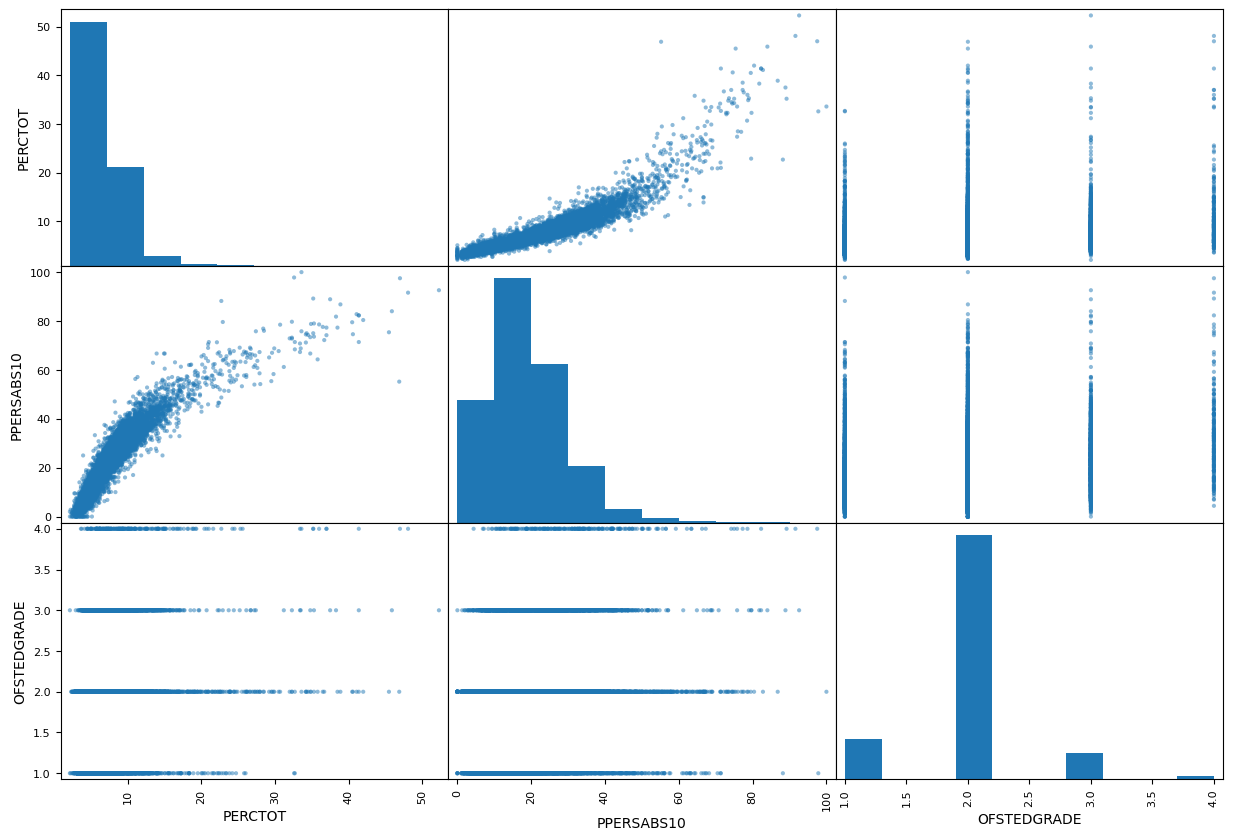

In [31]:
# Make a scatter matrix of numeric columns
pd.plotting.scatter_matrix(numer_cols, figsize=(15, 10), alpha=0.5)
plt.show()


In [32]:
# No null values found in numeric columns
num_finder = pd.DataFrame(numer_cols.isnull().sum()).reset_index()
num_finder


,index,0
0,PERCTOT,0
1,PPERSABS10,0
2,OFSTEDGRADE,0


In [33]:
cat_finder = pd.DataFrame(cat_cols.isnull().sum()).reset_index()
cat_finder


,index,0
0,MINORGROUP,0
1,SCHOOLTYPE,0
2,GENDER,0
3,RELCHAR,2088
4,ADMPOL,518
5,OFSTEDRATING,0


### Missing value analysis
Analysing which null features to keep in our categorical dataset
This search list shows all categorical columns with null values that could potentially be imputed

However, chose not to impute these values and kept the null column once the data was unpivoted using getdummies

It is appropriate to keep all nulls related to 'RELCHAR' 'ADMPOL' as the number of nulls are too high to remove, none cause a weakness in the model by keeping them


**Note no imputation was needed.

In [34]:
search_list = cat_finder.loc[cat_finder[0] != 0, 'index'].values
print(search_list)


['RELCHAR' 'ADMPOL']


In [35]:
def get_description(column_name, schema):

    """
    This function allows us to lookup the description of column variables

    Parameters:
    column_name (string): The column.
    schema (pandas.DataFrame): The data dictionary

    Returns:
    desc (string): The description from the schema.
    """

    return schema.loc[schema['Field Name'] == column_name,
                             'Description'].values[0]


search_list = [col for col in df.columns if 'ofsted' in col]
for col in search_list:
    print(get_description(col, schema_ofsted))

None of these information requires nulls to be removed, they may still be useful in modelling.

Therefore, missing values are also handled appropriately for both descriptive and ML techniques.

Leave drop_first to true to avoid
Multicollinearity which gives nonsensical R2 values.

In [36]:
# Create dummies for cat_cols
dummy_df = pd.get_dummies(cat_cols, prefix_sep='_',
                          dummy_na=True, drop_first=True)


In [37]:
df_clean = dummy_df.join(numer_cols, how='outer').reset_index()
df_clean.head()


,URN,MINORGROUP_Independent school,MINORGROUP_Maintained school,MINORGROUP_Special school,MINORGROUP_nan,SCHOOLTYPE_Academy special converter,SCHOOLTYPE_Academy special sponsor led,SCHOOLTYPE_Academy sponsor led,SCHOOLTYPE_City technology college,SCHOOLTYPE_Community school,...,ADMPOL_Selective,ADMPOL_nan,OFSTEDRATING_Outstanding,OFSTEDRATING_Requires improvement,OFSTEDRATING_Serious Weaknesses,OFSTEDRATING_Special Measures,OFSTEDRATING_nan,PERCTOT,PPERSABS10,OFSTEDGRADE
0,100000.0,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,5.2,9.8,1
1,100008.0,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,6.1,17.1,2
2,100009.0,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,6.0,15.2,2
3,100010.0,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,8.7,32.7,2
4,100011.0,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,5.5,14.7,2


Let's check that we have removed al objects before we begin modeling

In [38]:
df_clean.dtypes.value_counts()


bool       59
float64     3
int64       1
Name: count, dtype: int64

In [39]:
# Check for potential target columns for binary classification
[col for col in df_clean.columns if 'OFSTEDRATING' in col]


['OFSTEDRATING_Outstanding',
 'OFSTEDRATING_Requires improvement',
 'OFSTEDRATING_Serious Weaknesses',
 'OFSTEDRATING_Special Measures',
 'OFSTEDRATING_nan']

## Section 4: Data Modelling

### Initialising Model

In [40]:
# Model training
df_clean1 = df_clean.drop(columns=['URN',
                                   'OFSTEDRATING_Outstanding',
                                   'OFSTEDRATING_Requires improvement',
                                   'OFSTEDRATING_Special Measures',
                                   'OFSTEDRATING_nan',
                                   'OFSTEDGRADE']).copy()

target_column = 'OFSTEDRATING_Serious Weaknesses'

X = df_clean1.drop(columns=[target_column]).copy()
y = df_clean1[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3)

lr = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)


### Model Performance

In [41]:
# Model evaluation
r2 = (r2_score(y_test, y_pred))
print("R^2 score:", r2)

R^2 score: -54426664744249.21


The performance is nonsensical using linear regression, so now we try randomforest

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=20)

rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("R^2 score:", r2_score(y_test, y_pred_rf))


R^2 score: -0.36303909596841466


More reasonable scores, however still a weak performance

## Section 5: Evaluate the Results

#### 1) Which shool types have the highest Ofsted rating?

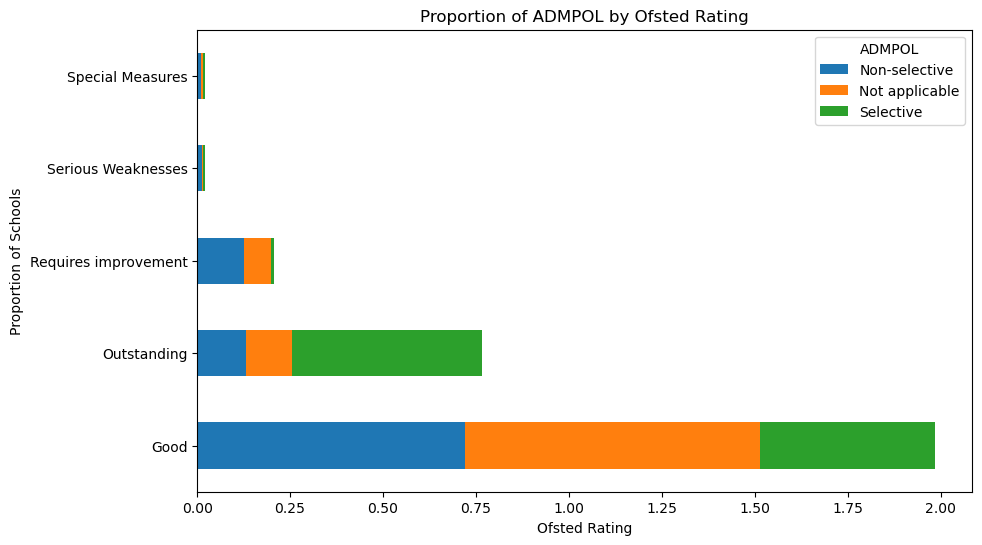

In [43]:
categorical_plot('ADMPOL')


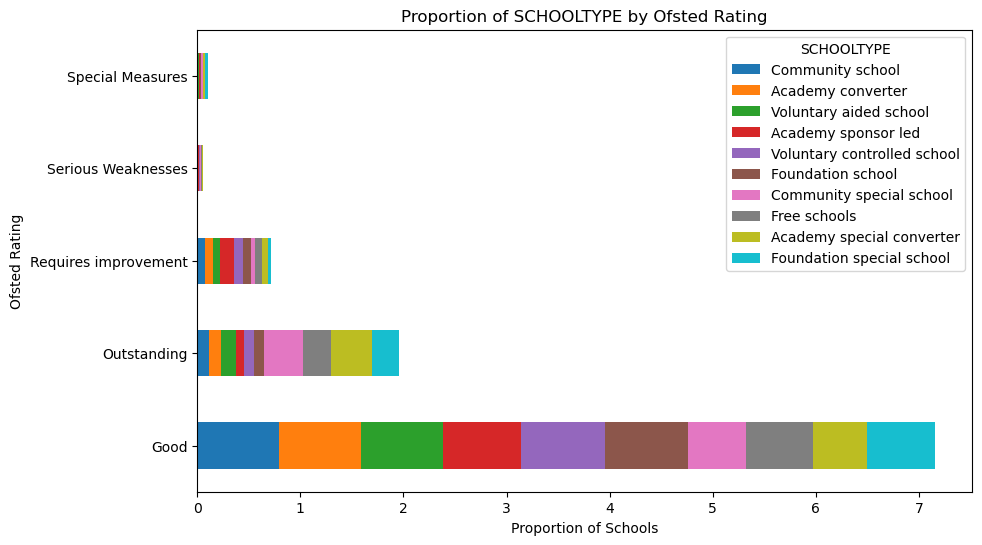

In [44]:
categorical_plot_filtered('SCHOOLTYPE',df)


From this evaluation, Selective schools are awarded substantially more Outstanding scores for their Ofsted reports. 
Likewise non-selective schools are more likely to be scored as a serious weakness.

Academy special converter schools and Community special schools perform well in Ofsted inspections. 

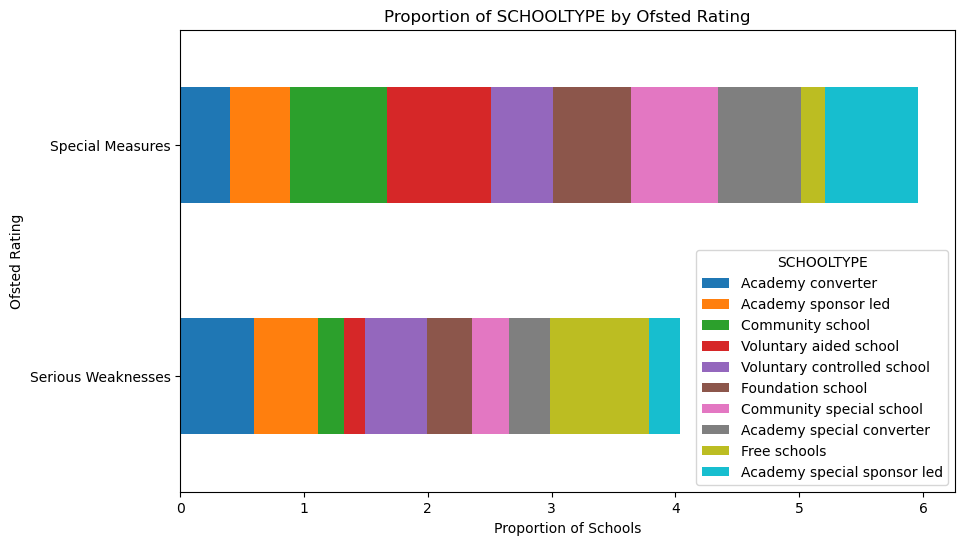

In [45]:
# Taking a closer look into those schools under grade 4 rating
categorical_plot_filtered('SCHOOLTYPE',df.loc[df['OFSTEDGRADE'] == 4])


Free schools and Academy converters on average perform worse in Ofsted inspections.

#### 2) Which schools by gender enrolment have the highest Ofsted ratings?


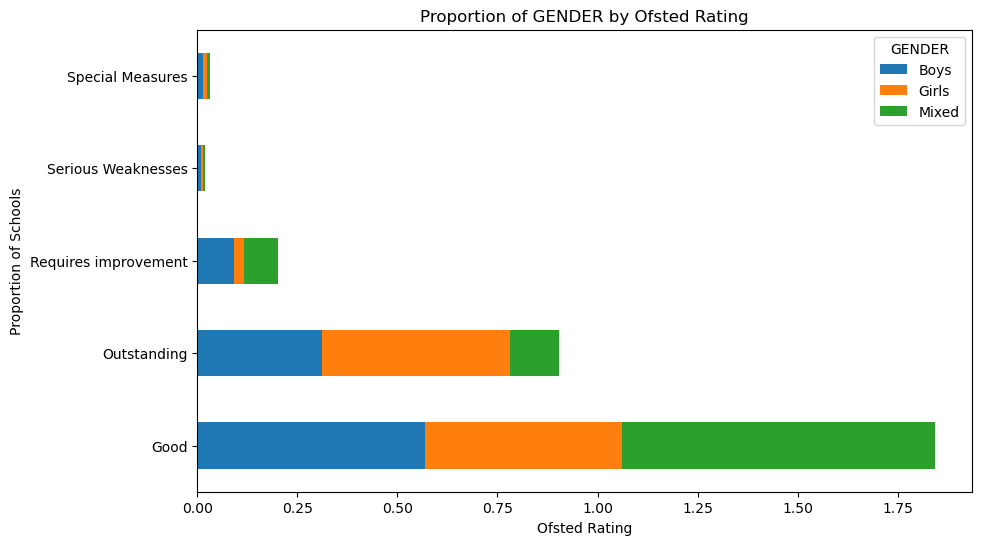

In [46]:
categorical_plot('GENDER')

From here we can understand all girls schools outperform all-boys schools.
Additionally single gender schools perform better getting either an 'Outstanding' or 'Good' report from Ofsted compared to mixed-gender schools. Potentially absences could also explain the differences in scores. Suprisingly, mixed schools have lower absences.

In [47]:
df.groupby('GENDER')['PERCTOT'].mean()


GENDER
Boys     10.146114
Girls     7.345000
Mixed     6.743203
Name: PERCTOT, dtype: float64

Here we can evaluate the percentage of school-tyoes with persistent absenteeism > 10% for each student.

In [48]:
df.groupby('GENDER')['PPERSABS10'].mean()


GENDER
Boys     26.773057
Girls    21.229000
Mixed    18.630002
Name: PPERSABS10, dtype: float64

#### 3) Are there differences in Ofsted ratings based on religious charter?

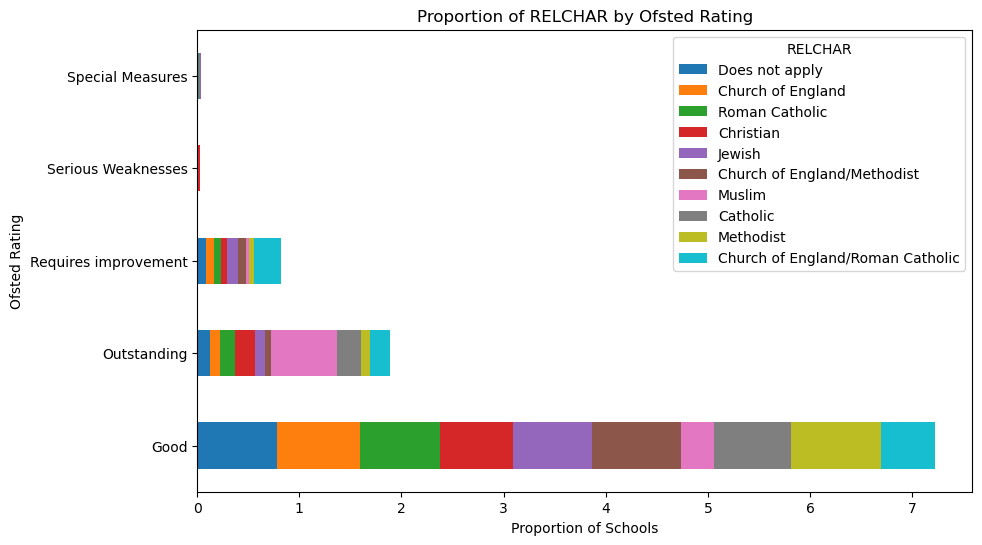

In [49]:
categorical_plot_filtered('RELCHAR', df)


Multiple conclusions can be made from here.
Muslim community schools perform substantially better in Ofsted ratings than non-religious chartered schools.
The Church of England makes a large proportion of schools that require improvement

#### 4) What is the average % of absense for schools that require improvement by Ofsted?

In [50]:
df_clean1.PERCTOT.mean()


6.782224453929199

The average percentage of overall absense in schools within the UK for 2022-23 was 6.78%.

The average absence for schools requiring improvement on average are once their >8%.

In [51]:
df.groupby('OFSTEDRATING')['PERCTOT'].mean()


OFSTEDRATING
Good                     6.635919
Outstanding              6.358780
Requires improvement     8.182292
Serious Weaknesses      10.846667
Special Measures        11.974419
Name: PERCTOT, dtype: float64

/Users/abiibrahim/.conda/envs/python312/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/abiibrahim/.conda/envs/python312/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


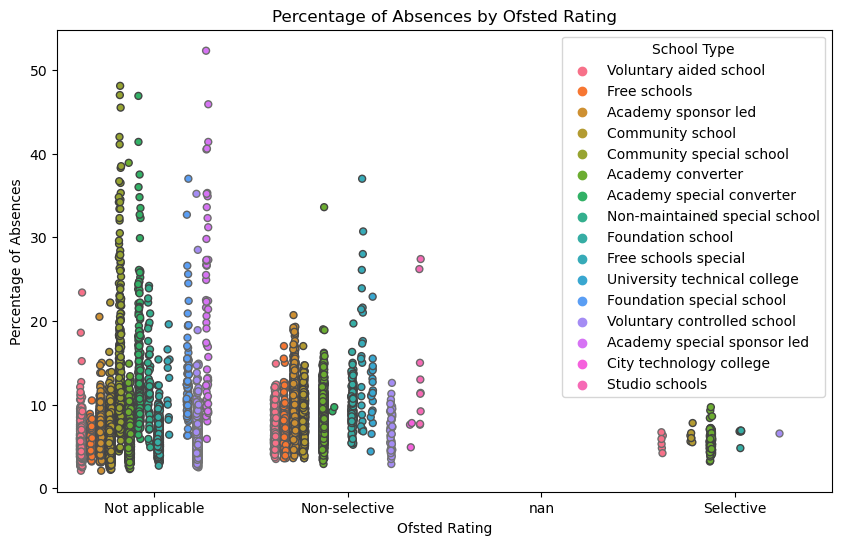

In [52]:
# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.stripplot(x='ADMPOL', y='PERCTOT', hue='SCHOOLTYPE', data=df, jitter=True, dodge=True, linewidth=1)
plt.title('Percentage of Absences by Ofsted Rating')
plt.xlabel('Ofsted Rating')
plt.ylabel('Percentage of Absences')
plt.legend(title='School Type')
plt.show()


Taking into account absense can help in concluding that this factor has a large influence on the feedback that Ofsted gives.
From the graph above non-selective schools have much higher absenses than selective schools which may indicate the differences in final Ofsted reports recieved back. 

## Section 6: Conclusions

My motivation to carry out this research was to understand if Ofsted inspections in the UK are influenced by intrinsic school characteristics as opposed to the actual observed quality of teaching.

Through a comprehensive analysis of Ofsted inspection reports, school demographic data, and educational outcomes, this study was able to determine whether factors such as school type, socio-economic status, and historical performance play a deterministic role in Ofsted ratings. The findings aim to contribute to the ongoing debate on the fairness and effectiveness of educational evaluations and provide recommendations for policy improvements.

The machine learning model itself was weak in confirming these characteristics determined the Ofsted rating. 

It also suggests the invaluablity of Ofsted reports. It does not mirror standard indicators nor can it replace league tables. Instead, they offer a valuable assessment of the quality of education provided. Schools have significant agency in influencing their ratings through high-quality teaching and effective management. These findings underscore the importance of continuous improvement in educational practices and reaffirm the credibility of Ofsted as a measure of school performance.
